In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
import time

In [2]:
from plot_functions import plot_results
from plot_functions import plot_results_by_month
from helpers import day_ahead_forecast
from helpers import prepare_tcn_features

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

In [4]:
file_path = os.path.join(current_directory, 'data_augmented/X_small.csv')
X_small = pd.read_csv(file_path, index_col = 0)

file_path = os.path.join(current_directory, 'data_augmented/timestamps.csv')
timestamps = pd.read_csv(file_path, index_col = 0)

In [5]:
df = X_small 

In [6]:
df['timestamp'] = timestamps
df.set_index("timestamp", inplace=True)

df.index = pd.to_datetime(df.index)
df = df.asfreq('H')  # 'H' for hourly frequency

In [7]:
df

,power_consumption,ghi,temp,wind,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_holiday,is_daylight
timestamp,,,,,,,,,,,
2022-04-13 10:00:00+00:00,0.21837,2.31866,0.44842,-0.83739,0,1,0,0,0,0,1
2022-04-13 11:00:00+00:00,-0.11143,2.09107,0.56725,-0.36810,0,1,0,0,0,0,1
2022-04-13 12:00:00+00:00,-0.16639,1.98543,0.69246,0.11499,0,1,0,0,0,0,1
2022-04-13 13:00:00+00:00,-0.03585,1.27027,0.76656,0.01837,0,1,0,0,0,0,1
2022-04-13 14:00:00+00:00,0.30769,1.71318,0.79978,-0.17487,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17 01:00:00+00:00,-1.06418,-0.65983,-0.05753,-0.23008,0,0,1,0,0,0,0
2024-06-17 02:00:00+00:00,-1.05848,-0.65983,-0.09075,-0.21628,0,0,1,0,0,0,0
2024-06-17 03:00:00+00:00,-1.02523,-0.65983,-0.07669,-0.25768,0,0,1,0,0,0,0


In [8]:
target_col = "power_consumption"
exog_cols = ['temp'] # [col for col in df.columns if col not in target_col]
window_length = 168  # 7 days
forecast_horizon = 24  # Next 24 hours

In [9]:
# Step 1: Train-Test Split
train_size = int(len(df) * 0.95)  # Determine initial train size based on 80%
initial_test_start = train_size  

while df.index[initial_test_start].hour != 11: # Adjust test start to align with the next occurrence of 11 AM
    initial_test_start += 1

final_test_end = len(df) - 1
while df.index[final_test_end].hour != 10: # Adjust test end to align with the last 10 AM in the dataset
    final_test_end -= 1

train = df.iloc[:initial_test_start]
test = df.iloc[initial_test_start:final_test_end+1]  # Include the last index

In [10]:
X, y, timestamps = prepare_tcn_features(df, target_col, exog_cols, window_length, forecast_horizon, include_forecast=True)
X_train, y_train, timestamps_train = prepare_tcn_features(train, target_col, exog_cols, window_length, forecast_horizon, include_forecast=True)
X_test, y_test, timestamps_test = prepare_tcn_features(test, target_col, exog_cols, window_length, forecast_horizon, include_forecast=True)

In [11]:
import torch
import torch.nn as nn

class TemporalConvNet(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        """
        Temporal Convolutional Network for Power Consumption Forecasting.

        Parameters:
            input_size (int): Number of input features.
            output_size (int): Number of output features (forecast horizon).
            num_channels (list): Number of channels in each TCN layer.
            kernel_size (int): Size of the convolution kernel.
            dropout (float): Dropout rate.
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size - 1)),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        """
        Forward pass of the TCN.

        Input:
            x: Shape (batch_size, seq_length, input_size).
        Output:
            y: Shape (batch_size, output_size).
        """
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_size, seq_length)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last time step
        x = self.linear(x)
        return x


In [12]:
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


In [13]:
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import DataLoader, TensorDataset

# Set up Time Series Split
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare feature and target tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

# Cross-validation results
cv_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tensor)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # Split data into training and validation
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
    
    # Create DataLoader for the fold
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    # Initialize the model for the fold
    input_size = X.shape[2]  # Number of input features
    output_size = y.shape[1]  # Forecast horizon
    hidden_channels = [32, 64, 32]  # Adjusted architecture for regularization
    kernel_size = 3
    dropout_rate = 0.3
    model = TemporalConvNet(input_size, output_size, hidden_channels, kernel_size=kernel_size, dropout=dropout_rate).to(device)
    
    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    # Train the model
    num_epochs = 10
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                val_loss += criterion(predictions, batch_y).item()
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch + 1}: Train Loss = {epoch_loss:.4f}, Validation Loss = {val_loss:.4f}")
        
        # Save the best model for this fold
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save({
                'model_state_dict': model.state_dict(),
                'input_size': input_size,
                'output_size': output_size,
                'hidden_channels': hidden_channels,
                'kernel_size': kernel_size,
                'dropout': dropout_rate,
                'X_train_tensor': X_train.cpu(),
                'X_test_tensor': X_val.cpu(),
                'y_train_tensor': y_train.cpu(),
                'y_test_tensor': y_val.cpu(),
            }, "best_tcn_model_and_data_crossvalidation.pth")
        
    # Save the best validation loss for this fold
    cv_results.append(best_val_loss)
    print(f"Best Validation Loss for Fold {fold + 1}: {best_val_loss:.4f}")

# Cross-validation summary
mean_val_loss = sum(cv_results) / len(cv_results)
print(f"\nCross-Validation Results: Mean Validation Loss = {mean_val_loss:.4f}")



Fold 1/5
Epoch 1: Train Loss = 0.6031, Validation Loss = 1.2389
Epoch 2: Train Loss = 0.4345, Validation Loss = 1.2865
Epoch 3: Train Loss = 0.3658, Validation Loss = 1.3153
Epoch 4: Train Loss = 0.3295, Validation Loss = 1.2244
Epoch 5: Train Loss = 0.3115, Validation Loss = 1.2136
Epoch 6: Train Loss = 0.3020, Validation Loss = 1.2197
Epoch 7: Train Loss = 0.2913, Validation Loss = 1.2122
Epoch 8: Train Loss = 0.2839, Validation Loss = 1.2099
Epoch 9: Train Loss = 0.2757, Validation Loss = 1.2052
Epoch 10: Train Loss = 0.2729, Validation Loss = 1.1977
Best Validation Loss for Fold 1: 1.1977

Fold 2/5
Epoch 1: Train Loss = 0.8498, Validation Loss = 0.6647
Epoch 2: Train Loss = 0.5871, Validation Loss = 0.5834
Epoch 3: Train Loss = 0.5088, Validation Loss = 0.5929
Epoch 4: Train Loss = 0.4872, Validation Loss = 0.5262
Epoch 5: Train Loss = 0.4721, Validation Loss = 0.5104
Epoch 6: Train Loss = 0.4602, Validation Loss = 0.5118
Epoch 7: Train Loss = 0.4540, Validation Loss = 0.4973
Epoc

In [14]:
# Restore the best model state from cross-validation
model.load_state_dict(best_model_state)

# Set model to evaluation mode
model.eval()

# Perform predictions on the test set
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Test features
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)  # Test targets

    test_predictions = model(X_test_tensor)  # (num_test_samples, forecast_horizon)

# Convert predictions and targets to numpy for analysis
test_predictions_np = test_predictions.cpu().numpy()  # Predicted values
y_test_np = y_test_tensor.cpu().numpy()  # Ground truth

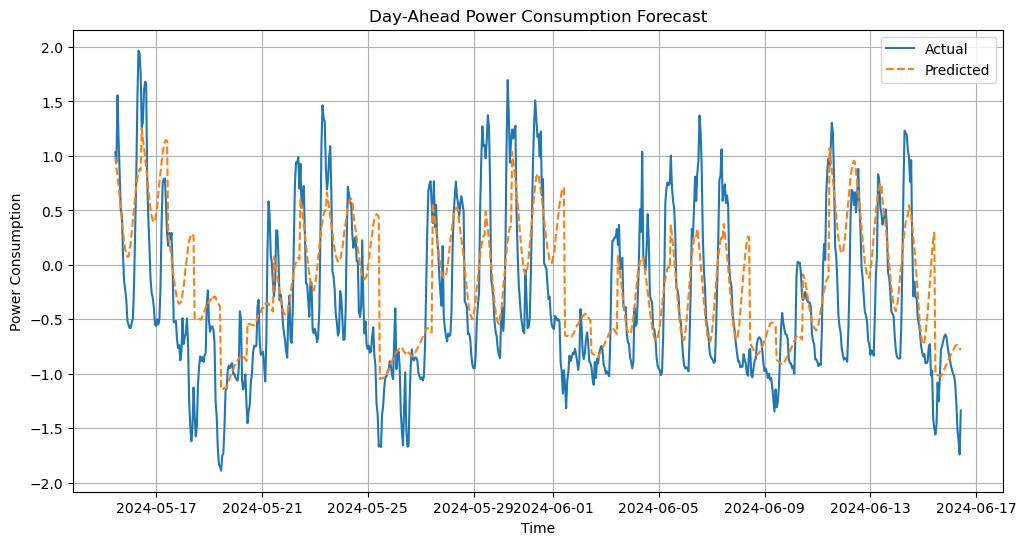

In [15]:
num_samples, forecast_horizon = test_predictions_np.shape  

prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0, num_samples+forecast_horizon-1)]

predictions = day_ahead_forecast(test_predictions_np, prediction_timestamps)
actuals = day_ahead_forecast(y_test_np, prediction_timestamps)
plot_results(predictions, actuals, "Day-Ahead Power Consumption Forecast")

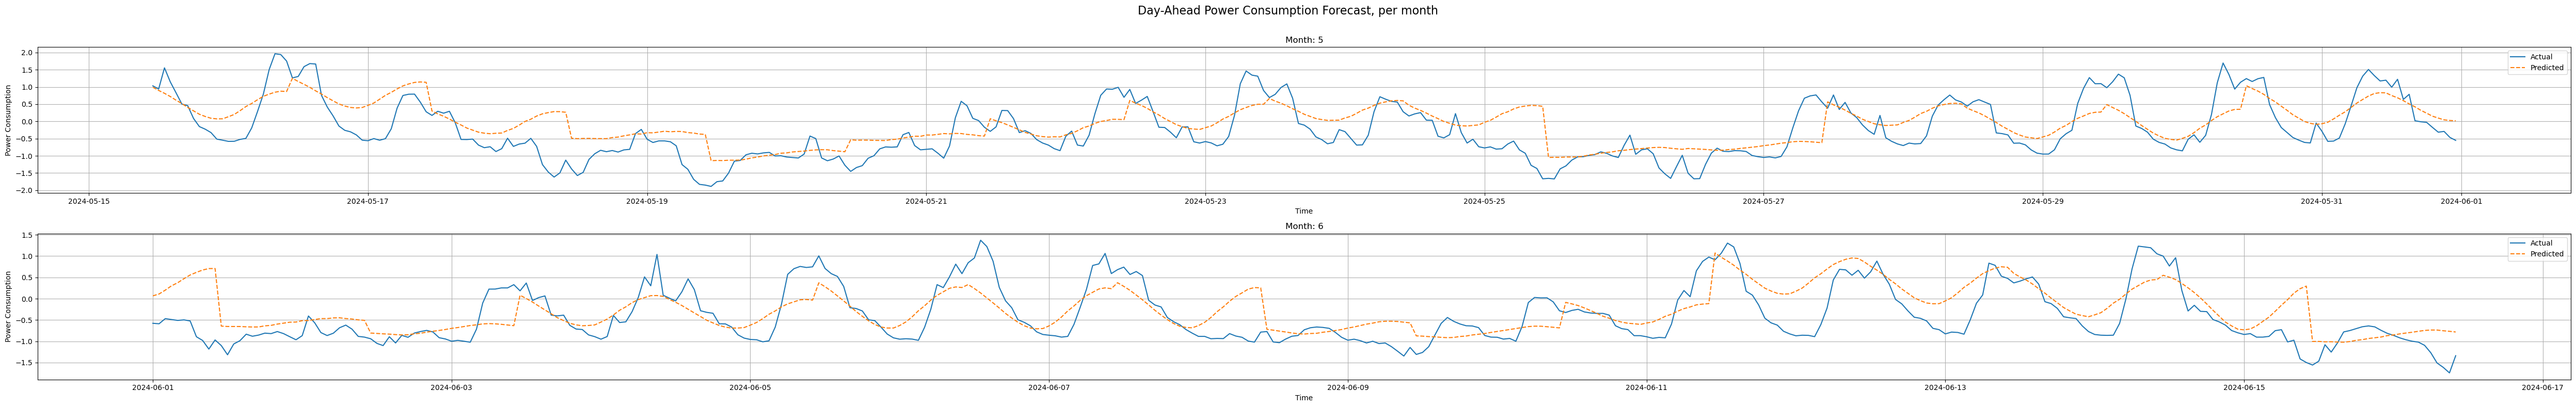

In [16]:
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month")

In [17]:
# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [18]:
models = ['TCN prediction at 10 am', 'TCN predictions at all time steps']
error_dict = {'model': models,
              'RMSE': np.zeros(len(models)),
              'MAE': np.zeros(len(models)),
              'ME': np.zeros(len(models)),
              'MAPE': np.zeros(len(models))
    }
errors = pd.DataFrame(error_dict).set_index("model")
errors = pd.DataFrame(error_dict).set_index("model")

In [19]:
errors.loc[models[0], 'RMSE'] = root_mean_squared_error(actuals, predictions)
errors.loc[models[0], 'MAE'] = mean_absolute_error(actuals, predictions)
errors.loc[models[0], 'ME'] = max_error(actuals, predictions)
errors.loc[models[0], 'MAPE'] = mean_absolute_percentage_error(actuals, predictions)

In [21]:
y_pred = test_predictions.cpu().detach().numpy()  
y_true = y_test_tensor.cpu().numpy()  
errors.loc[models[1], 'RMSE'] = root_mean_squared_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'MAE'] = mean_absolute_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'ME'] = max_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'MAPE'] = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
errors

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.55831,0.43017,2.10533,1.07274
TCN predictions at all time steps,0.57042,0.42834,2.26053,1.10143


In [23]:
errors / np.max(errors, axis = 0)

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.97878,1.00000,0.93134,0.97396
TCN predictions at all time steps,1.00000,0.99575,1.00000,1.00000
